# Set up environment

In [1]:
# convert jupyter to python
# !jupyter-nbconvert --to script gan_mlp_lstm_fx.ipynb

In [2]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# control GPU memory usages
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [3]:
# check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0922 06:07:52.193442 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0922 06:07:52.194602 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0922 06:07:52.195350 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0922 06:07:52.199202 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# check devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17863510397263216673
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11791147196232866690
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5818111485457861213
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4228513792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4192227520692043153
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
]


# Import modules

In [5]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams["font.size"] = 18
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Dropout, Input, Reshape, Bidirectional, Embedding
from keras.layers import LSTM, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD, Adamax, RMSprop
from keras_ordered_neurons import ONLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard

from tqdm import tqdm, tqdm_notebook

# Import data

For data acquisition and pre-processing, see data_process_fx.ipynb 

In [6]:
# !ls 

## Get train data

In [7]:
# get train dataset
df_train = pd.read_csv("USDJPY/usdjpy_train.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2010-2017.csv")
# df_train = pd.read_csv("USDJPY/usdjpy_train_2015-2017.csv")

if "Date" in df_train.columns:
    df_train.sort_values("Date", inplace=True)
else:
    df_train.sort_values("datetime", inplace=True)   
df_train.head()
# df_train.dtypes

,datetime,Open
0,2018-01-02 10:00:00,112.37
1,2018-01-03 10:00:00,112.33
2,2018-01-04 10:00:00,112.61
3,2018-01-05 10:00:00,113.19
4,2018-01-08 10:00:00,113.22


## Get test data

In [8]:
# get test dataset
df_test0 = pd.read_csv("USDJPY/usdjpy_test.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")
# df_test0 = pd.read_csv("USDJPY/usdjpy_test_2018-2019.csv")

if "Date" in df_train.columns:
    df_test0.sort_values("Date", inplace=True)
else:
    df_test0.sort_values("datetime", inplace=True)
df_test0.head()

,datetime,Open
0,2019-01-01 10:00:00,109.59
1,2019-01-02 10:00:00,108.94
2,2019-01-03 10:00:00,107.63
3,2019-01-04 10:00:00,108.01
4,2019-01-07 10:00:00,108.19


## Convert price data to diff price data

In [9]:
# http://philipperemy.github.io/keras-stateful-lstm/

In [10]:
# df_train["diff"] = np.where(df_train["Open"].diff()>=0, 1, -1) 
# df_test0["diff"] = np.where(df_test0["Open"].diff()>=0, 1, -1) 
df_train["diff"] = np.where(df_train["Open"].diff()>0, 1, 0) 
df_test0["diff"] = np.where(df_test0["Open"].diff()>0, 1, 0) 
df_train.head()

,datetime,Open,diff
0,2018-01-02 10:00:00,112.37,0
1,2018-01-03 10:00:00,112.33,0
2,2018-01-04 10:00:00,112.61,1
3,2018-01-05 10:00:00,113.19,1
4,2018-01-08 10:00:00,113.22,1


# Set up parameter and process data shape

In [11]:
# set up parameters and features for training
batch_size = 60 #60
lstm_batch_size = 60 #60 #timestep
epochs = 200 #100
split_validate_test = 0.5
selected_features = ["Open"] # ["Open", "Vol"] # the first column should be the one would like to predict
selected_features = ["diff"] # ["Open", "Vol"] # the first column should be the one would like to predict

In [12]:
# process train data
data_train = df_train[selected_features].values 
print ("data_train", data_train.shape)
benchmark_actual_train = df_train[selected_features].iloc[lstm_batch_size:].values
print ("benchmark_actual_train", benchmark_actual_train.shape)

# calculate number of features
num_features = data_train.shape[1]
print ("num_features", num_features)

# normalise data
scaler_train = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = scaler_train.fit_transform(data_train)
scaler_train_output = MinMaxScaler(feature_range = (0, 1))
data_train_scaled_output = scaler_train_output.fit_transform(data_train[:,0:1])
# data_train_scaled = data_train

# convert data shape for lstm
def convert_data_shape_for_lstm(data_scaled, lstm_batch_size):
    features0 = []
    labels0 = []
    for i in range(lstm_batch_size, len(data_scaled)):
        features0.append(data_scaled[i-lstm_batch_size:i, 0:data_scaled.shape[1]])
        labels0.append(data_scaled[i, 0])
    # reshape
    features0, labels0 = np.array(features0), np.array(labels0)
    features0 = np.reshape(features0, (features0.shape[0], features0.shape[1], data_scaled.shape[1]))
    print ("features", features0.shape)
    print ("labels", labels0.shape)
    return features0, labels0

train_features, train_labels = convert_data_shape_for_lstm(data_train_scaled, lstm_batch_size)

data_train (259, 1)
benchmark_actual_train (199, 1)
num_features 1
features (199, 60, 1)
labels (199,)


In [13]:
# process test data
data_total = pd.concat((df_train[selected_features], df_test0[selected_features]), axis=0)
print ("data_total", data_total.shape)
data_test = data_total[len(data_total) - len(df_test0) - lstm_batch_size + 1:].values
print ("data_test", data_test.shape)

# normalise data
scaler_test = MinMaxScaler(feature_range = (0, 1))
data_test_scaled = scaler_train.fit_transform(data_test)
# data_test_scaled = data_test

# convert data shape for lstm
test_features0, test_labels0 = convert_data_shape_for_lstm(data_test_scaled, lstm_batch_size)

# seperate validate and test
validate_features = test_features0[0:int(len(test_features0)*split_validate_test)]
test_features = test_features0[int(len(test_features0)*split_validate_test):]
validate_labels = test_labels0[0:int(len(test_labels0)*split_validate_test)]
test_labels = test_labels0[int(len(test_labels0)*split_validate_test):]

benchmark_actual_test = data_test[int((len(test_features0))*split_validate_test)+lstm_batch_size:,]

print ("test_features", test_features.shape)
print ("validate_features", validate_features.shape)
print ("benchmark_actual_test", benchmark_actual_test.shape)

data_total (411, 1)
data_test (211, 1)
features (151, 60, 1)
labels (151,)
test_features (76, 60, 1)
validate_features (75, 60, 1)
benchmark_actual_test (76, 1)


In [14]:
def plot_timeseries(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax2 = ax1.twinx()
        ax2.plot(real_data, color='b', label="real", linewidth=3.0)
        ax2.ticklabel_format(useOffset=False)
        # plt.ylim([105,119])
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.xlabel("Day")
        plt.ylabel("Price")        
        ax1.legend()
        ax1.set_title('USDJPY: Epoch={}'.format(epoch), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()
    
def plot_timeseries2(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    print (len(generated_timeseries.T[0]), len(real_data))
    plt.figure(figsize=(8,5))
    for i in range(generated_timeseries.T.shape[0]):
        plt.rcParams["font.size"] = 18
        ax1 = plt.subplot(1, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict', linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        ax1.plot(real_data, color='b', label="real", linewidth=3.0)
        ax1.ticklabel_format(useOffset=False)
        plt.xlabel("Day")
        plt.ylabel("Price (USDJPY)")        
        ax1.legend()
        ax1.set_title('{}_{}_{}'.format(training_type, discriminator_type, generator_type), fontsize=20)
    plt.tight_layout()
    plt.savefig('output/%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()    

In [15]:
def predict_model_and_plot(case, model_case, selected_feature, features, model, benchmark_actual):
    lstm_predict = model.predict(features)
    print (lstm_predict.shape, features.shape)
    if selected_feature == "Open":
        lstm_predict = scaler_train_output.inverse_transform(lstm_predict)
    plot_timeseries(epochs, case, "", model_case, lstm_predict, benchmark_actual)
    plot_timeseries2(epochs, case, "", model_case, lstm_predict, benchmark_actual)   
    return lstm_predict

In [16]:
def calculate_confusion_matrix(selected_feature, model_prediction):
    print ("selected_feature", selected_feature)
    if selected_feature == "Open":
        y_true = np.where(np.diff(benchmark_actual_test.T[0])>0, 1, -1) 
        y_pred = np.where(np.diff(model_prediction[:,0])>0, 1, -1) 
    elif selected_feature == "diff":
        y_true = np.where(benchmark_actual_test.T[0]>0, 1, -1) 
        y_pred = np.where(model_prediction[:,0]>0.5, 1, -1) 
    cm = confusion_matrix(y_true, y_pred)
    print (cm)
    return cm

# LSTM

In [17]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

In [18]:
# lstm_model
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=500, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=500))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 1))
    lstm_model.add(Activation("sigmoid"))
    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])

    return lstm_model
lstm_model = create_lstm_model()
# lstm_model.summary()

W0922 06:07:52.886715 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 06:07:53.675151 140559289521984 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0922 06:07:55.999938 140559289521984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [19]:
print (train_features.shape, train_labels.shape)
lstm_history = lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size,
                              validation_data=(validate_features, validate_labels),
                              shuffle=False)
lstm_score, lstm_acc = lstm_model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=0)
print (lstm_score, lstm_acc)

(199, 60, 1) (199,)


W0922 06:07:56.251561 140559289521984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 199 samples, validate on 75 samples
Epoch 1/200
199/199 [==============================] - 6s 31ms/step - loss: 0.2621 - acc: 0.5126 - val_loss: 0.2528 - val_acc: 0.4400
Epoch 2/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2532 - acc: 0.4673 - val_loss: 0.2514 - val_acc: 0.4800
Epoch 3/200
199/199 [==============================] - 2s 12ms/step - loss: 0.2509 - acc: 0.4271 - val_loss: 0.2511 - val_acc: 0.4667
Epoch 4/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2501 - acc: 0.4724 - val_loss: 0.2511 - val_acc: 0.4267
Epoch 5/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2494 - acc: 0.5075 - val_loss: 0.2516 - val_acc: 0.5067
Epoch 6/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2485 - acc: 0.5578 - val_loss: 0.2563 - val_acc: 0.5067
Epoch 7/200
199/199 [==============================] - 2s 12ms/step - loss: 0.2480 - acc: 0.5528 - val_loss: 0.2612 - val_acc: 0.4267
Epoch 8/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.2132 - acc: 0.6784 - val_loss: 0.3236 - val_acc: 0.5200
Epoch 62/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2042 - acc: 0.6784 - val_loss: 0.3244 - val_acc: 0.4667
Epoch 63/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2024 - acc: 0.6683 - val_loss: 0.2883 - val_acc: 0.5200
Epoch 64/200
199/199 [==============================] - 2s 11ms/step - loss: 0.2104 - acc: 0.6482 - val_loss: 0.3335 - val_acc: 0.4533
Epoch 65/200
199/199 [==============================] - 2s 12ms/step - loss: 0.2130 - acc: 0.6784 - val_loss: 0.3291 - val_acc: 0.5333
Epoch 66/200
199/199 [==============================] - 2s 11ms/step - loss: 0.1885 - acc: 0.6985 - val_loss: 0.2827 - val_acc: 0.5600
Epoch 67/200
199/199 [==============================] - 2s 11ms/step - loss: 0.1893 - acc: 0.6985 - val_loss: 0.3017 - val_acc: 0.5067
Epoch 68/200
199/199 [==============================] - 2s 12ms/step

199/199 [==============================] - 2s 11ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.3942 - val_acc: 0.4933
Epoch 122/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.3998 - val_acc: 0.4933
Epoch 123/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.4007 - val_acc: 0.4667
Epoch 124/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3994 - val_acc: 0.4933
Epoch 125/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.4289 - val_acc: 0.4533
Epoch 126/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0288 - acc: 0.9598 - val_loss: 0.4068 - val_acc: 0.5600
Epoch 127/200
199/199 [==============================] - 2s 11ms/step - loss: 0.1599 - acc: 0.7990 - val_loss: 0.3885 - val_acc: 0.5067
Epoch 128/200
199/199 [==============================] - 2s 11

199/199 [==============================] - 2s 12ms/step - loss: 2.8396e-05 - acc: 1.0000 - val_loss: 0.3985 - val_acc: 0.5333
Epoch 181/200
199/199 [==============================] - 2s 12ms/step - loss: 2.5222e-05 - acc: 1.0000 - val_loss: 0.3990 - val_acc: 0.5333
Epoch 182/200
199/199 [==============================] - 2s 12ms/step - loss: 2.0152e-05 - acc: 1.0000 - val_loss: 0.3989 - val_acc: 0.5467
Epoch 183/200
199/199 [==============================] - 2s 11ms/step - loss: 1.6650e-05 - acc: 1.0000 - val_loss: 0.3995 - val_acc: 0.5467
Epoch 184/200
199/199 [==============================] - 2s 11ms/step - loss: 1.3399e-05 - acc: 1.0000 - val_loss: 0.3998 - val_acc: 0.5467
Epoch 185/200
199/199 [==============================] - 2s 11ms/step - loss: 1.1687e-05 - acc: 1.0000 - val_loss: 0.4008 - val_acc: 0.5467
Epoch 186/200
199/199 [==============================] - 2s 11ms/step - loss: 9.9506e-06 - acc: 1.0000 - val_loss: 0.4014 - val_acc: 0.5467
Epoch 187/200
199/199 [===========

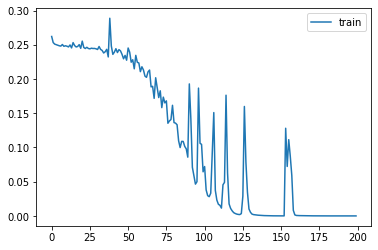

In [20]:
# plot history
plt.plot(lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

(199, 1) (199, 60, 1)
199 199


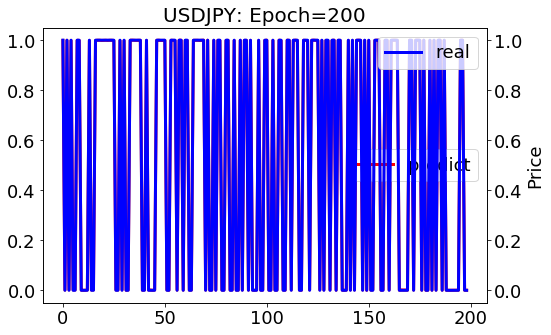

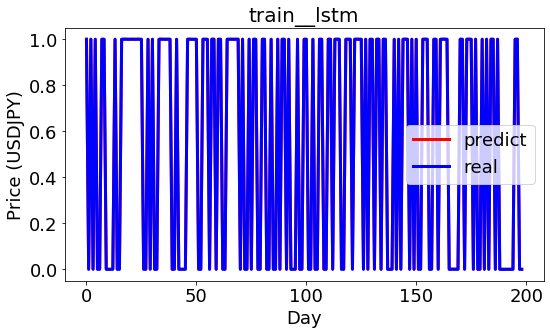

In [21]:
train_lstm_prediction = predict_model_and_plot("train", "lstm", selected_features[0], train_features, lstm_model, benchmark_actual_train)

(76, 1) (76, 60, 1)
76 76


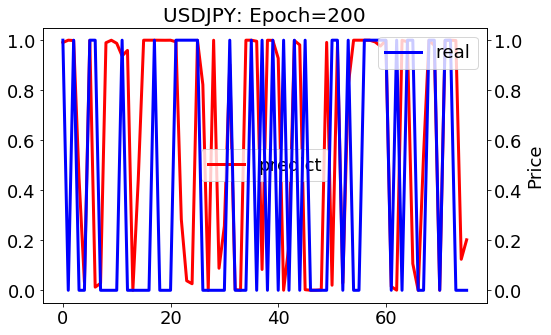

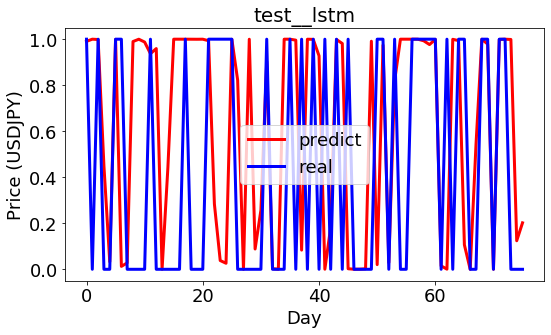

In [22]:
lstm_predictions = predict_model_and_plot("test", "lstm", selected_features[0], test_features, lstm_model, benchmark_actual_test)

In [23]:
calculate_confusion_matrix(selected_features[0], lstm_predictions)

selected_feature diff
[[20 23]
 [10 23]]


array([[20, 23],
       [10, 23]])

# Ordered-neurons LSTM

In [24]:
# https://arxiv.org/abs/1810.09536
# https://github.com/CyberZHG/keras-ordered-neurons/blob/master/README.md

In [25]:
def create_on_lstm_model():
    on_lstm_model = Sequential()
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True, 
                                        input_shape=(train_features.shape[1], train_features.shape[2])))
    on_lstm_model.add(Dropout(0.01))
    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5, return_sequences=True))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(ONLSTM(units=500, chunk_size=5))
    on_lstm_model.add(Dropout(0.01))

    on_lstm_model.add(Dense(units = 1))
    
    on_lstm_model.add(Activation("sigmoid"))

    on_lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=['accuracy'])
    
    return on_lstm_model
on_lstm_model = create_on_lstm_model()
on_lstm_model.summary()

# def create_on_lstm_model():
#     on_lstm_model = Sequential()
#     on_lstm_model.add(ONLSTM(units=50, chunk_size=5, return_sequences=True, 
#                                         input_shape=(train_features.shape[1], train_features.shape[2])))

#     on_lstm_model.add(ONLSTM(units=50, chunk_size=5))
#     on_lstm_model.add(Dropout(0.01))

#     on_lstm_model.add(Dense(units = 1))

#     on_lstm_model.compile(optimizer = 'RMSprop', 
#                        loss = 'mean_squared_error', metrics=['accuracy'])
    
#     return on_lstm_model
# on_lstm_model = create_on_lstm_model()
# on_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
onlstm_1 (ONLSTM)            (None, 60, 500)           1104400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_2 (ONLSTM)            (None, 60, 500)           2202200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_3 (ONLSTM)            (None, 60, 500)           2202200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 500)           0         
_________________________________________________________________
onlstm_4 (ONLSTM)            (None, 500)              

In [26]:
# on_lstm_history = on_lstm_model.fit(train_features, train_labels, epochs = epochs, batch_size = batch_size)
on_lstm_history = on_lstm_model.fit(train_features, train_labels, 
                                    epochs = epochs, batch_size = batch_size,
                                    validation_data=(validate_features, validate_labels),
                                    shuffle=False)
on_lstm_score, on_lstm_acc = on_lstm_model.evaluate(test_features, test_labels, 
                                                    batch_size=batch_size, verbose=0)
print (on_lstm_score, on_lstm_acc)

Train on 199 samples, validate on 75 samples
Epoch 1/200
199/199 [==============================] - 8s 39ms/step - loss: 0.2651 - acc: 0.5327 - val_loss: 0.2489 - val_acc: 0.5467
Epoch 2/200
199/199 [==============================] - 3s 16ms/step - loss: 0.2490 - acc: 0.5427 - val_loss: 0.2489 - val_acc: 0.5467
Epoch 3/200
199/199 [==============================] - 3s 15ms/step - loss: 0.2490 - acc: 0.5427 - val_loss: 0.2490 - val_acc: 0.5467
Epoch 4/200
199/199 [==============================] - 3s 16ms/step - loss: 0.2491 - acc: 0.5427 - val_loss: 0.2490 - val_acc: 0.5467
Epoch 5/200
199/199 [==============================] - 3s 16ms/step - loss: 0.2491 - acc: 0.5427 - val_loss: 0.2491 - val_acc: 0.5467
Epoch 6/200
199/199 [==============================] - 3s 17ms/step - loss: 0.2491 - acc: 0.5427 - val_loss: 0.2491 - val_acc: 0.5467
Epoch 7/200
199/199 [==============================] - 3s 16ms/step - loss: 0.2492 - acc: 0.5427 - val_loss: 0.2491 - val_acc: 0.5467
Epoch 8/200
199/1

199/199 [==============================] - 3s 16ms/step - loss: 0.2355 - acc: 0.6131 - val_loss: 0.3048 - val_acc: 0.4933
Epoch 62/200
199/199 [==============================] - 3s 16ms/step - loss: 0.2451 - acc: 0.6181 - val_loss: 0.3002 - val_acc: 0.4800
Epoch 63/200
199/199 [==============================] - 3s 15ms/step - loss: 0.2314 - acc: 0.6382 - val_loss: 0.2993 - val_acc: 0.4533
Epoch 64/200
199/199 [==============================] - 3s 15ms/step - loss: 0.2253 - acc: 0.6683 - val_loss: 0.3127 - val_acc: 0.4533
Epoch 65/200
199/199 [==============================] - 3s 14ms/step - loss: 0.2276 - acc: 0.6583 - val_loss: 0.3035 - val_acc: 0.4533
Epoch 66/200
199/199 [==============================] - 3s 17ms/step - loss: 0.2269 - acc: 0.6482 - val_loss: 0.3142 - val_acc: 0.4533
Epoch 67/200
199/199 [==============================] - 3s 15ms/step - loss: 0.2325 - acc: 0.6281 - val_loss: 0.3234 - val_acc: 0.4533
Epoch 68/200
199/199 [==============================] - 2s 12ms/step

199/199 [==============================] - 3s 17ms/step - loss: 0.1067 - acc: 0.8342 - val_loss: 0.4062 - val_acc: 0.4000
Epoch 122/200
199/199 [==============================] - 3s 16ms/step - loss: 0.1121 - acc: 0.8392 - val_loss: 0.4172 - val_acc: 0.4267
Epoch 123/200
199/199 [==============================] - 3s 17ms/step - loss: 0.1132 - acc: 0.8342 - val_loss: 0.4023 - val_acc: 0.4400
Epoch 124/200
199/199 [==============================] - 3s 17ms/step - loss: 0.1272 - acc: 0.8090 - val_loss: 0.4376 - val_acc: 0.3467
Epoch 125/200
199/199 [==============================] - 3s 16ms/step - loss: 0.1134 - acc: 0.8492 - val_loss: 0.3925 - val_acc: 0.4000
Epoch 126/200
199/199 [==============================] - 3s 16ms/step - loss: 0.1036 - acc: 0.8442 - val_loss: 0.4292 - val_acc: 0.4533
Epoch 127/200
199/199 [==============================] - 3s 16ms/step - loss: 0.1175 - acc: 0.8543 - val_loss: 0.4361 - val_acc: 0.3733
Epoch 128/200
199/199 [==============================] - 3s 17

199/199 [==============================] - 3s 17ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.4400
Epoch 182/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.4400
Epoch 183/200
199/199 [==============================] - 3s 17ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.4400
Epoch 184/200
199/199 [==============================] - 3s 17ms/step - loss: 8.8729e-04 - acc: 1.0000 - val_loss: 0.4472 - val_acc: 0.4533
Epoch 185/200
199/199 [==============================] - 3s 16ms/step - loss: 6.9369e-04 - acc: 1.0000 - val_loss: 0.4478 - val_acc: 0.4533
Epoch 186/200
199/199 [==============================] - 3s 16ms/step - loss: 5.6873e-04 - acc: 1.0000 - val_loss: 0.4490 - val_acc: 0.4533
Epoch 187/200
199/199 [==============================] - 3s 16ms/step - loss: 4.7049e-04 - acc: 1.0000 - val_loss: 0.4502 - val_acc: 0.4533
Epoch 188/200
199/199 [=======================

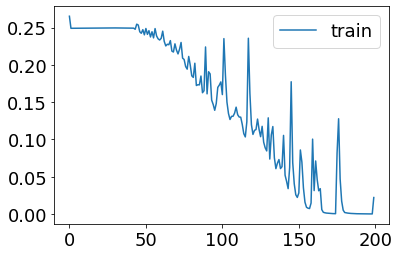

In [27]:
# plot history
plt.plot(on_lstm_history.history['loss'], label='train')
plt.legend()
plt.show()

(199, 1) (199, 60, 1)
199 199


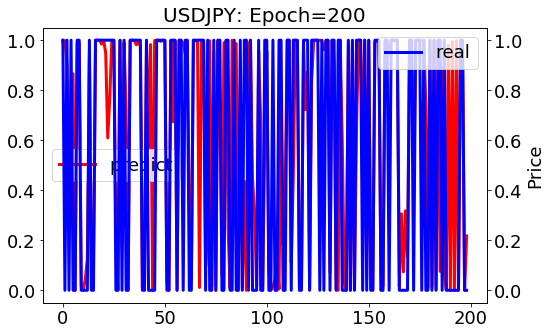

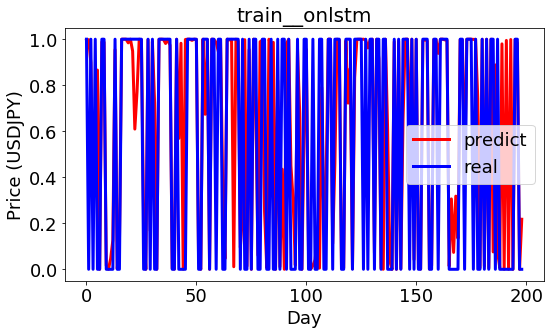

In [28]:
train_on_lstm_predict = predict_model_and_plot("train", "onlstm", selected_features[0], train_features, on_lstm_model, benchmark_actual_train)
# train_on_lstm_predict = on_lstm_model.predict(train_features)
# print (train_on_lstm_predict.shape, train_features.shape)
# train_on_lstm_predict = scaler_train_output.inverse_transform(train_on_lstm_predict)
# plot_timeseries(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)
# plot_timeseries2(0, "train", "", "onlstm", train_on_lstm_predict, benchmark_actual_train)

(76, 1) (76, 60, 1)
76 76


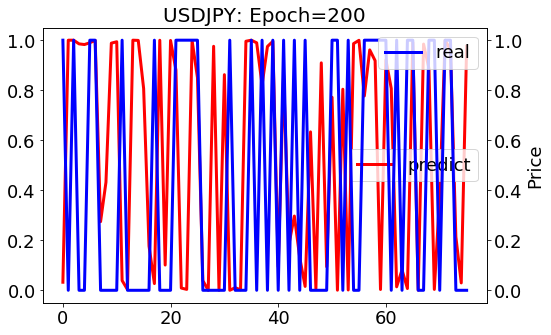

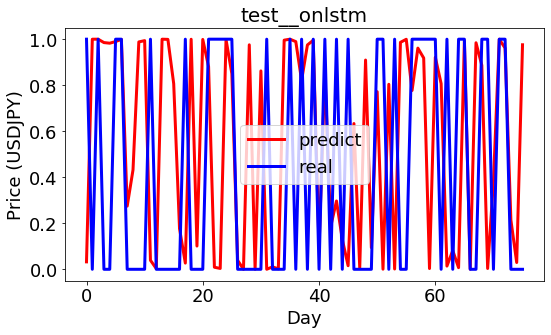

In [29]:
on_lstm_predictions = predict_model_and_plot("test", "onlstm", selected_features[0], test_features, on_lstm_model, benchmark_actual_test)
# on_lstm_predictions = on_lstm_model.predict(test_features)
# plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, 
#                  data_test_scaled[int(lstm_batch_size+len(test_features0)*split_validate_test):])
# on_lstm_predictions = scaler_train_output.inverse_transform(on_lstm_predictions)
# plot_timeseries(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)
# plot_timeseries2(0, "test", "", "onlstm", on_lstm_predictions, benchmark_actual_test)

In [30]:
calculate_confusion_matrix(selected_features[0], on_lstm_predictions)

selected_feature diff
[[20 23]
 [14 19]]


array([[20, 23],
       [14, 19]])

In [31]:
calculate_confusion_matrix(selected_features[0], on_lstm_predictions)

selected_feature diff
[[20 23]
 [14 19]]


array([[20, 23],
       [14, 19]])

# GAN

In [32]:
# https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3
# https://qiita.com/taku-buntu/items/0093a68bfae0b0ff879d
# https://qiita.com/yoyoyo_/items/56c6fcbd5a853460f506

## Generator and Discriminator

In [33]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=1))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(128))
    discriminator.add(LeakyReLU(alpha=0.1))
    discriminator.add(Dense(units=1, activation='sigmoid'))    
    discriminator.compile(loss='binary_crossentropy', optimizer='RMSprop')
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [34]:
def create_gan(discriminator, generator, generator_type="lstm"):
    discriminator.trainable=False

    if generator_type=="mlp":
        gan_input = Input(shape=(num_features,))
    else:
        gan_input = Input(shape=(lstm_batch_size, num_features))
    print (gan_input.shape)
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    gan.compile(loss='mean_squared_error', optimizer=opt)
#     gan.compile(loss='binary_crossentropy', optimizer='adam')
                          
    return gan
gan = create_gan(d,on_lstm_model)
gan.summary()

(?, 60, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 1)             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 7711501   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 165377    
Total params: 7,876,878
Trainable params: 7,711,501
Non-trainable params: 165,377
_________________________________________________________________


# Training

In [35]:
def training(epochs=1, batch_size=60, discriminator_type="gan", generator_type="lstm"):

    #Loading the data
    batch_count = int(train_features.shape[0] / batch_size)
    print ("batch_count", batch_count)
    print ("batch_size", batch_size)
    print ("lstm_batch_size", lstm_batch_size)
    
    # Creating GAN generator
    if generator_type == "lstm":
        generator = create_lstm_model()
    elif generator_type == "on_lstm":
        generator = create_on_lstm_model()
    elif generator_type == "mlp":
        generator = create_generator()
       
    # Creating GAN discriminator
    if discriminator_type == "gan":
        discriminator = create_discriminator()
    elif discriminator_type == "wgan":
        discriminator = create_wgan_discriminator()

    # Creating GAN 
    gan = create_gan(discriminator, generator, generator_type)

    # Set up label for valid and fake conditions
    valid = np.ones((batch_size, 1)) * 1.0 # prevent overconfidence by penalising the discriminator (1=>0.9)
    # valid = np.ones((batch_size, 1)) * 0.9 # prevent overconfidence by penalising the discriminator (1=>0.9)
    fake = np.zeros((batch_size, 1))    
    actual_data_train_all = data_train_scaled[lstm_batch_size:,0]
    losses = []
    
    for epoch in range(1,epochs+1 ):
        for i in range(batch_count):
            
            # Generate fake time-series from lstm model input
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                generated_timeseries = generator.predict(noise)               
            else:
                train_timeseries_batch = train_features[batch_size*i:batch_size*(i+1),:,:]
                generated_timeseries = generator.predict(train_timeseries_batch) 

            # Train the discriminator (real classified as ones and generated as zeros)
            actual_data_train = actual_data_train_all[batch_size*i:batch_size*(i+1)]
            discriminator.trainable=True
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([actual_data_train, generated_timeseries[:,0]])
            y = np.concatenate([valid, fake])
            d_loss = discriminator.train_on_batch(X, y)
            discriminator.trainable=False
            
            # Train Generator: combined model  (stacked generator and discriminator)
            # Train the generator (wants discriminator to mistake images as real)  
            if generator_type == "mlp":
                noise = np.random.uniform(-1, 1, (batch_size, num_features))
                g_loss = gan.train_on_batch(noise, valid)
            else:
                g_loss = gan.train_on_batch(train_timeseries_batch, valid)

            # Print out losses
            print ("Epoch: %d, Batch_count: %d, [D loss: %f] [G loss: %f]" % (epoch, batch_count, d_loss, g_loss))
            losses.append([epoch, d_loss, g_loss])
        
        if epoch == 1 or epoch % 100 == 0:
            if generator_type == "mlp":
                noise_train = np.random.uniform(-1, 1, (train_features.shape[0], num_features))
                generated_timeseries_predict_train = generator.predict(noise_train)
                noise_test = np.random.uniform(-1, 1, (test_features.shape[0], num_features))
                generated_timeseries_predict_test = generator.predict(noise_test)
            else:
                generated_timeseries_predict_train = generator.predict(train_features)
                generated_timeseries_predict_test = generator.predict(test_features)
            
            # Inverse transform using train fit_transform model for both train and test sets
            train_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_train)
            test_predictions = scaler_train_output.inverse_transform(generated_timeseries_predict_test)
            
            # Plot train and test
            plot_timeseries(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            plot_timeseries2(epoch, "train", discriminator_type, generator_type, train_predictions, benchmark_actual_train)
            plot_timeseries2(epoch, "test", discriminator_type, generator_type, test_predictions, benchmark_actual_test)
            
            # Save model
            generator.save('train_model/generator_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
            gan.save('train_model/gan_model_' + str(discriminator_type) + '_' + str(generator_type) + '_' + str(epoch) + '.h5')
    return test_predictions, losses, generator

# GAN + ON-LSTM

batch_count 3
batch_size 60
lstm_batch_size 60
(?, 60, 1)
Epoch: 1, Batch_count: 3, [D loss: 0.694420] [G loss: 0.209287]
Epoch: 1, Batch_count: 3, [D loss: 0.696892] [G loss: 0.252146]
Epoch: 1, Batch_count: 3, [D loss: 0.685924] [G loss: 0.239631]
199 199
76 76
Epoch: 2, Batch_count: 3, [D loss: 0.678497] [G loss: 0.236247]
Epoch: 2, Batch_count: 3, [D loss: 0.670991] [G loss: 0.255841]
Epoch: 2, Batch_count: 3, [D loss: 0.658450] [G loss: 0.241262]
Epoch: 3, Batch_count: 3, [D loss: 0.643418] [G loss: 0.250689]
Epoch: 3, Batch_count: 3, [D loss: 0.626954] [G loss: 0.259233]
Epoch: 3, Batch_count: 3, [D loss: 0.604023] [G loss: 0.273131]
Epoch: 4, Batch_count: 3, [D loss: 0.573518] [G loss: 0.266431]
Epoch: 4, Batch_count: 3, [D loss: 0.547747] [G loss: 0.319257]
Epoch: 4, Batch_count: 3, [D loss: 0.520805] [G loss: 0.255385]
Epoch: 5, Batch_count: 3, [D loss: 0.499111] [G loss: 0.400235]
Epoch: 5, Batch_count: 3, [D loss: 0.466415] [G loss: 0.315074]
Epoch: 5, Batch_count: 3, [D los

Epoch: 43, Batch_count: 3, [D loss: 0.526305] [G loss: 0.477008]
Epoch: 43, Batch_count: 3, [D loss: 0.497945] [G loss: 0.384669]
Epoch: 43, Batch_count: 3, [D loss: 0.513161] [G loss: 0.430415]
Epoch: 44, Batch_count: 3, [D loss: 0.522050] [G loss: 0.367301]
Epoch: 44, Batch_count: 3, [D loss: 0.498812] [G loss: 0.482084]
Epoch: 44, Batch_count: 3, [D loss: 0.518228] [G loss: 0.351752]
Epoch: 45, Batch_count: 3, [D loss: 0.523466] [G loss: 0.440619]
Epoch: 45, Batch_count: 3, [D loss: 0.495572] [G loss: 0.413722]
Epoch: 45, Batch_count: 3, [D loss: 0.512653] [G loss: 0.401245]
Epoch: 46, Batch_count: 3, [D loss: 0.521014] [G loss: 0.395944]
Epoch: 46, Batch_count: 3, [D loss: 0.496213] [G loss: 0.456733]
Epoch: 46, Batch_count: 3, [D loss: 0.515081] [G loss: 0.358016]
Epoch: 47, Batch_count: 3, [D loss: 0.522845] [G loss: 0.445652]
Epoch: 47, Batch_count: 3, [D loss: 0.495747] [G loss: 0.405160]
Epoch: 47, Batch_count: 3, [D loss: 0.512616] [G loss: 0.410138]
Epoch: 48, Batch_count: 3

Epoch: 85, Batch_count: 3, [D loss: 0.496022] [G loss: 0.432154]
Epoch: 85, Batch_count: 3, [D loss: 0.513235] [G loss: 0.397975]
Epoch: 86, Batch_count: 3, [D loss: 0.521005] [G loss: 0.399119]
Epoch: 86, Batch_count: 3, [D loss: 0.496029] [G loss: 0.431694]
Epoch: 86, Batch_count: 3, [D loss: 0.513212] [G loss: 0.398462]
Epoch: 87, Batch_count: 3, [D loss: 0.521005] [G loss: 0.399018]
Epoch: 87, Batch_count: 3, [D loss: 0.496035] [G loss: 0.431373]
Epoch: 87, Batch_count: 3, [D loss: 0.513196] [G loss: 0.398816]
Epoch: 88, Batch_count: 3, [D loss: 0.521004] [G loss: 0.398920]
Epoch: 88, Batch_count: 3, [D loss: 0.496040] [G loss: 0.431188]
Epoch: 88, Batch_count: 3, [D loss: 0.513187] [G loss: 0.398818]
Epoch: 89, Batch_count: 3, [D loss: 0.521005] [G loss: 0.398921]
Epoch: 89, Batch_count: 3, [D loss: 0.496040] [G loss: 0.431370]
Epoch: 89, Batch_count: 3, [D loss: 0.513196] [G loss: 0.398502]
Epoch: 90, Batch_count: 3, [D loss: 0.521005] [G loss: 0.399263]
Epoch: 90, Batch_count: 3

Epoch: 127, Batch_count: 3, [D loss: 0.521031] [G loss: 0.395761]
Epoch: 127, Batch_count: 3, [D loss: 0.496219] [G loss: 0.429558]
Epoch: 127, Batch_count: 3, [D loss: 0.513110] [G loss: 0.403368]
Epoch: 128, Batch_count: 3, [D loss: 0.521025] [G loss: 0.398286]
Epoch: 128, Batch_count: 3, [D loss: 0.496074] [G loss: 0.425356]
Epoch: 128, Batch_count: 3, [D loss: 0.512938] [G loss: 0.405174]
Epoch: 129, Batch_count: 3, [D loss: 0.521046] [G loss: 0.398563]
Epoch: 129, Batch_count: 3, [D loss: 0.496059] [G loss: 0.424696]
Epoch: 129, Batch_count: 3, [D loss: 0.512914] [G loss: 0.405249]
Epoch: 130, Batch_count: 3, [D loss: 0.521047] [G loss: 0.398618]
Epoch: 130, Batch_count: 3, [D loss: 0.496056] [G loss: 0.424544]
Epoch: 130, Batch_count: 3, [D loss: 0.512909] [G loss: 0.405128]
Epoch: 131, Batch_count: 3, [D loss: 0.521045] [G loss: 0.398385]
Epoch: 131, Batch_count: 3, [D loss: 0.496068] [G loss: 0.424866]
Epoch: 131, Batch_count: 3, [D loss: 0.512920] [G loss: 0.404480]
Epoch: 132

Epoch: 168, Batch_count: 3, [D loss: 0.512878] [G loss: 0.404432]
Epoch: 169, Batch_count: 3, [D loss: 0.521037] [G loss: 0.396190]
Epoch: 169, Batch_count: 3, [D loss: 0.496194] [G loss: 0.427929]
Epoch: 169, Batch_count: 3, [D loss: 0.513039] [G loss: 0.406366]
Epoch: 170, Batch_count: 3, [D loss: 0.521063] [G loss: 0.398387]
Epoch: 170, Batch_count: 3, [D loss: 0.496068] [G loss: 0.423850]
Epoch: 170, Batch_count: 3, [D loss: 0.512885] [G loss: 0.407349]
Epoch: 171, Batch_count: 3, [D loss: 0.521080] [G loss: 0.399124]
Epoch: 171, Batch_count: 3, [D loss: 0.496028] [G loss: 0.422651]
Epoch: 171, Batch_count: 3, [D loss: 0.512846] [G loss: 0.407477]
Epoch: 172, Batch_count: 3, [D loss: 0.521082] [G loss: 0.399249]
Epoch: 172, Batch_count: 3, [D loss: 0.496022] [G loss: 0.422217]
Epoch: 172, Batch_count: 3, [D loss: 0.512833] [G loss: 0.407561]
Epoch: 173, Batch_count: 3, [D loss: 0.521084] [G loss: 0.399352]
Epoch: 173, Batch_count: 3, [D loss: 0.496016] [G loss: 0.421941]
Epoch: 173

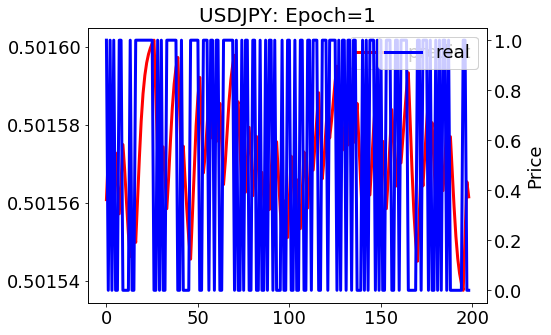

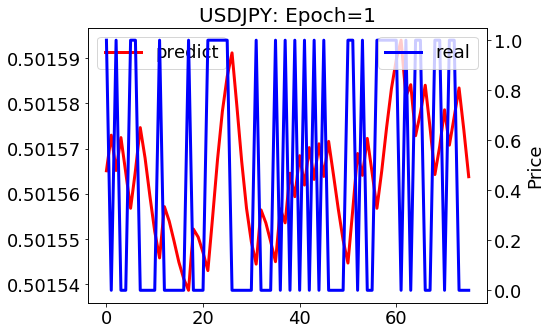

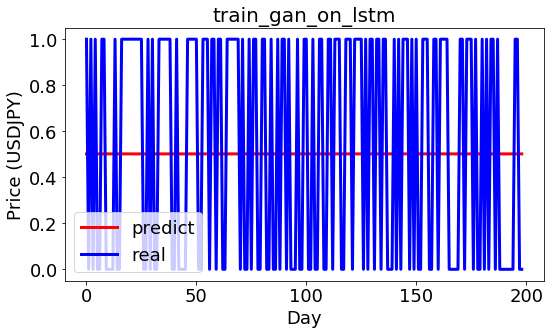

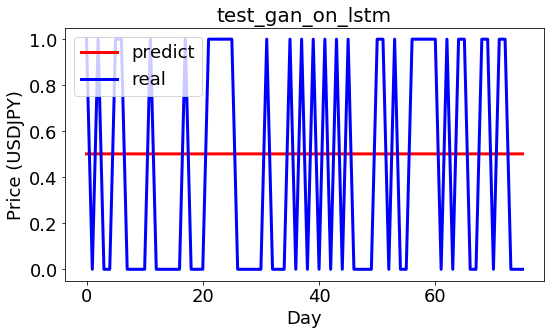

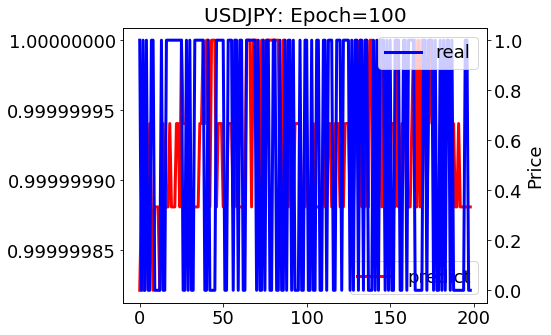

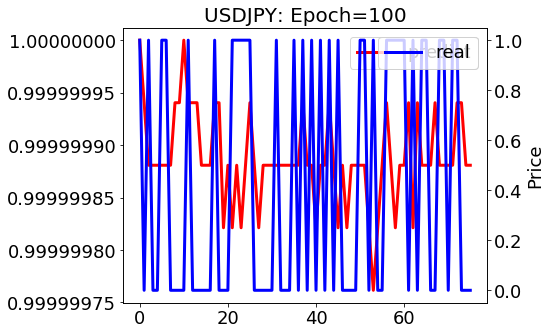

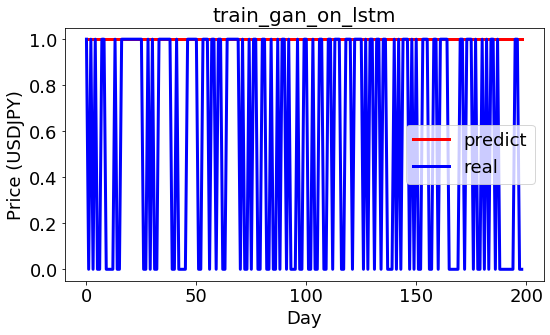

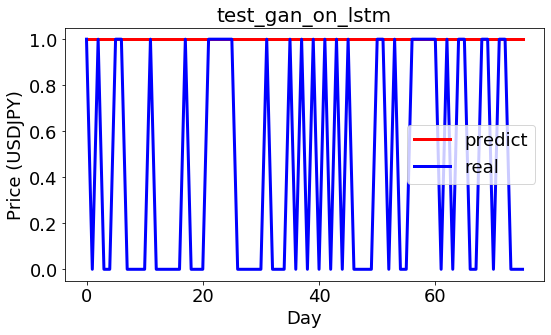

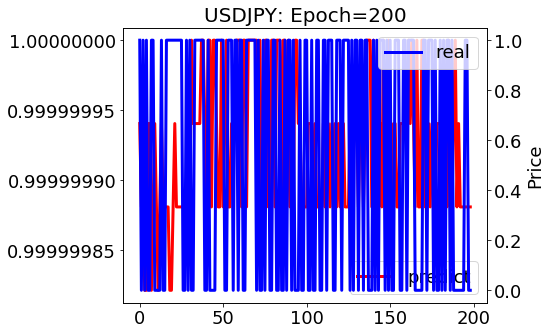

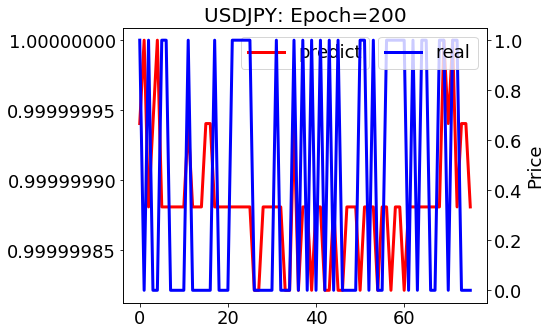

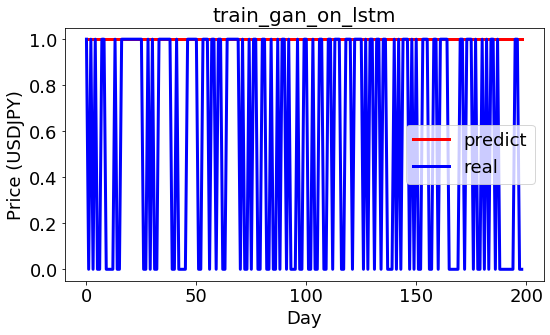

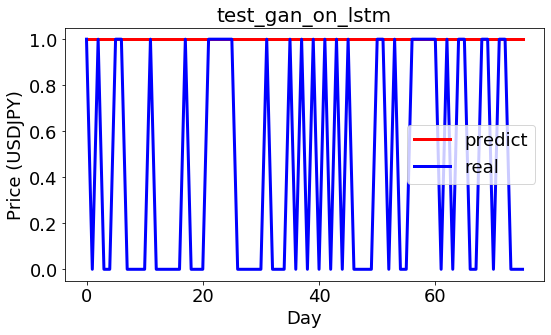

In [36]:
gan_onlstm_predictions, gan_onlstm_losses, gan_onlstm_generator = training(epochs, batch_size, "gan", "on_lstm")

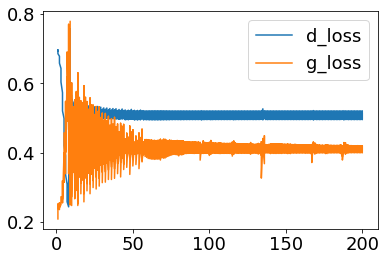

In [37]:
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[1], label='d_loss')
plt.plot(np.transpose(gan_onlstm_losses)[0], np.transpose(gan_onlstm_losses)[2], label='g_loss')
plt.legend()

In [38]:
calculate_confusion_matrix(selected_features[0], gan_onlstm_predictions)

selected_feature diff
[[ 0 43]
 [ 0 33]]


array([[ 0, 43],
       [ 0, 33]])

# Compare performance

In [39]:
def accuracy_evaluation(method, true, prediction):
    # mean absolute error
    mae = mean_absolute_error(true, prediction)
    # mean absolute percentage error
    mape = np.mean(np.abs((true - prediction) / true)) * 100
    # root mean squared error
    rmse = np.sqrt(mean_squared_error(true, prediction))
    # mean squared error
    mse = mean_squared_error(true, prediction)
    # correlation coefficient
    corr = np.corrcoef(np.concatenate((np.transpose(true), np.transpose(prediction)), axis=0))[0,1]
    print ("{}:\tmae:{:.5}\tmape:{:.5}\trmse:{:.5}\tmse:{:.5}\tcorr:{:.3}".format(method, mae, mape, rmse, mse, corr))
    return

In [40]:
accuracy_evaluation("lstm\t", benchmark_actual_test, lstm_predictions)
accuracy_evaluation("onlstm\t", benchmark_actual_test, on_lstm_predictions)
accuracy_evaluation("gan_onlstm", benchmark_actual_test, gan_onlstm_predictions)

lstm	:	mae:0.44636	mape:inf	rmse:0.64074	mse:0.41054	corr:0.157
onlstm	:	mae:0.5115	mape:inf	rmse:0.67434	mse:0.45474	corr:-0.0108
gan_onlstm:	mae:0.56579	mape:inf	rmse:0.75219	mse:0.56579	corr:-0.0112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


# Trading

In [41]:
abs(np.diff(benchmark_actual_test.T[0])).mean()

0.52

In [42]:
def trading_profit(actual, predict, trading_type):
    tc = 0.0015
    profit = 0
    profit2 = 0
    trade_vol = 100000
    transaction_count = 0
    answer = 0
    answer2 = 0
    ans_increase = 0
    ans_decrease = 0
    increase = 0
    decrease = 0
    for i in range(len(actual)-1):
        # print (actual[i], actual[i+1], predict[i], predict[i+1]) 
        if predict[i] <= predict[i+1]:
            trade_diff = actual[i+1] - actual[i]
            transaction_count += 1
        else:
            if trading_type == 'buy_only':
                trade_diff = 0
            else:
                trade_diff = actual[i] - actual[i+1]
                transaction_count += 1
        answer += abs(actual[i+1] - actual[i]) * trade_vol
        answer2 += (abs(actual[i+1] - actual[i])-tc) * trade_vol
        if actual[i+1] - actual[i] >=0:
            ans_increase += 1
            if  predict[i+1] >= predict[i]:
                increase += 1
        else:
            ans_decrease += 1
            if  predict[i+1] < predict[i]:
                decrease += 1
        profit += trade_diff * trade_vol
        profit2 += (trade_diff-tc) * trade_vol
        #print (i, abs(actual[i+1] - actual[i]))
    print ("\n[ANSWER] max profit:{:}, {:}".format(answer, answer2))
    print ("trading_type: {}\t transaction_count: {}\t total_profit: {}\t profit/max_profit: {:.4}".format(
        trading_type, transaction_count, profit, float(profit/answer*100)))
    print ("trading_type2: {}\t transaction_count: {}\t total_profit2: {}\t profit2/max_profit2: {:.4}".format(
        trading_type, transaction_count, profit2, float(profit2/answer2*100)))
    print ("ans_increase:{}\tans_decrease:{}\tincrease:{}\tdecrease:{}\t{:}".format(
        ans_increase, ans_decrease, increase, decrease, (increase+decrease)/(ans_increase+ans_decrease)*100,))
    return profit

In [43]:
lstm_predict1 = trading_profit(benchmark_actual_test, lstm_predictions[:,0], 'buy_only')
lstm_predict2 = trading_profit(benchmark_actual_test, lstm_predictions[:,0], 'buy_sell')


[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_only	 transaction_count: 32	 total_profit: [100000]	 profit/max_profit: 2.564
trading_type2: buy_only	 transaction_count: 32	 total_profit2: [88750.]	 profit2/max_profit2: 2.282
ans_increase:55	ans_decrease:20	increase:25	decrease:13	50.66666666666667

[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [300000]	 profit/max_profit: 7.692
trading_type2: buy_sell	 transaction_count: 75	 total_profit2: [288750.]	 profit2/max_profit2: 7.425
ans_increase:55	ans_decrease:20	increase:25	decrease:13	50.66666666666667


In [44]:
on_lstm_predict1 = trading_profit(benchmark_actual_test, on_lstm_predictions[:,0], 'buy_only')
on_lstm_predict2 = trading_profit(benchmark_actual_test, on_lstm_predictions[:,0], 'buy_sell')


[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_only	 transaction_count: 34	 total_profit: [-100000]	 profit/max_profit: -2.564
trading_type2: buy_only	 transaction_count: 34	 total_profit2: [-111250.]	 profit2/max_profit2: -2.861
ans_increase:55	ans_decrease:20	increase:25	decrease:11	48.0

[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [-100000]	 profit/max_profit: -2.564
trading_type2: buy_sell	 transaction_count: 75	 total_profit2: [-111250.]	 profit2/max_profit2: -2.861
ans_increase:55	ans_decrease:20	increase:25	decrease:11	48.0


In [45]:
gan_onlstm_predictions1 = trading_profit(benchmark_actual_test, gan_onlstm_predictions, 'buy_only')
gan_onlstm_predictions2 = trading_profit(benchmark_actual_test, gan_onlstm_predictions, 'buy_sell')


[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_only	 transaction_count: 58	 total_profit: [-100000]	 profit/max_profit: -2.564
trading_type2: buy_only	 transaction_count: 58	 total_profit2: [-111250.]	 profit2/max_profit2: -2.861
ans_increase:55	ans_decrease:20	increase:44	decrease:6	66.66666666666666

[ANSWER] max profit:[3900000], [3888750.]
trading_type: buy_sell	 transaction_count: 75	 total_profit: [-100000]	 profit/max_profit: -2.564
trading_type2: buy_sell	 transaction_count: 75	 total_profit2: [-111250.]	 profit2/max_profit2: -2.861
ans_increase:55	ans_decrease:20	increase:44	decrease:6	66.66666666666666
